# Debug wave-geometry model

With a basic state derived from model data, the wave geometry model creates noisy results. To ensure that this is an issue with the input data, and not with the python implementation, it is desireable to run the model on a very smooth basic state with an analytical formulation. Try the following two examples:

- Smooth polar vortex on beta plane with latitudinally constant temperature profile as in Harnik & Lindzen (2001);
  guassian-shaped jet, amplitude increases linearely with height (30-100m/s), tilts equatorward & widens with height (center around 2Ld at 2H & Ld at 10H);
  constant temperature (215K) in stratosphere (2-5 scale heights), maximum temperature (260K) at 7 scale heights, 225K at 10 scale heights;
  beta = 1.3 * 10^(-11) (s m)^(-1), Ld=10°, 
- 2D gaussian-shaped tropospheric jet

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cmocean.cm as cm

In [2]:
%cd ../src
from basicstate import Grid, buoancy_frequency, pv_gradient
from anywave import Matrix
import anywave as wave

/home/wolfgang/Arbeit/wavegeometry_model/src


In [3]:
# Input filenames
namelist = '../input/nml-debug'

outfile = '../input/debug-basicstate.nc'

## Pre-process

In [4]:
# BASIC STATE for a purely statrospheric polar vortex with a temperature profile dependent only on z

# read the namelist and define model grid
grid = Grid(namelist,bottom=2)

# zonal wind
center = (70 - 10*(grid.z[:,np.newaxis]/grid.param['Ho']-2)/8) * np.pi/180
width = (10 + 5*(grid.z[:,np.newaxis]/grid.param['Ho']-2)/8) * np.pi/180
ampli = (30 + 70*(grid.z[:,np.newaxis]/grid.param['Ho']-2)/8)

u = ampli * np.exp(-(grid.y[np.newaxis,:] - center)**2/(2/2*width**2))
u = u[np.newaxis,:,:]

# temperature
t = 215+30*(np.arctan(grid.z/grid.param['Ho']-6.5)+np.arctan(-(grid.z/grid.param['Ho']-8.5)*0.8))
t, u = np.broadcast_arrays(t[np.newaxis,:,np.newaxis],u)

In [5]:
# calculate squared buoancy frequency and pv gradient from in-situ temperature and zonal wind
N2 = buoancy_frequency(grid,t)
qy = pv_gradient(grid,u,N2)

basicstate = xr.Dataset(data_vars=dict(u=(('step','lev','lat'),u),
                                       qy=(('step','lev','lat'),qy),
                                       N2=(('step','lev','lat'),N2)),
                        coords=dict(lev=grid.z,lat=grid.y))
print(basicstate)

<xarray.Dataset>
Dimensions:  (step: 1, lev: 71, lat: 47)
Coordinates:
  * lev      (lev) float64 1.4e+04 1.528e+04 1.656e+04 ... 1.024e+05 1.037e+05
  * lat      (lat) float64 0.0 0.03415 0.0683 0.1024 ... 1.468 1.503 1.537 1.571
Dimensions without coordinates: step
Data variables:
    u        (step, lev, lat) float64 1.573e-20 2.342e-19 ... 3.973 2.604
    qy       (step, lev, lat) float64 2.283e-11 2.281e-11 ... -2.78e-11
    N2       (step, lev, lat) float64 0.0003626 0.0003626 ... 0.0003618


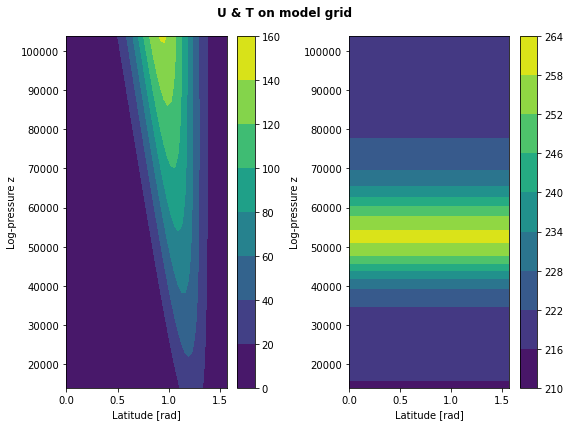

In [6]:
# plot U & T on model grid
fig, axes = plt.subplots(1,2,figsize=(8,6))

Cs = axes[0].contourf(grid.y,grid.z,np.squeeze(u))
axes[0].set_ylabel('Log-pressure z')
axes[0].set_xlabel('Latitude [rad]')
plt.colorbar(Cs,ax=axes[0])

Cs = axes[1].contourf(grid.y,grid.z,np.squeeze(t))
axes[1].set_ylabel('Log-pressure z')
axes[1].set_xlabel('Latitude [rad]')
plt.colorbar(Cs,ax=axes[1])

fig.suptitle('U & T on model grid',weight='bold')
fig.tight_layout()

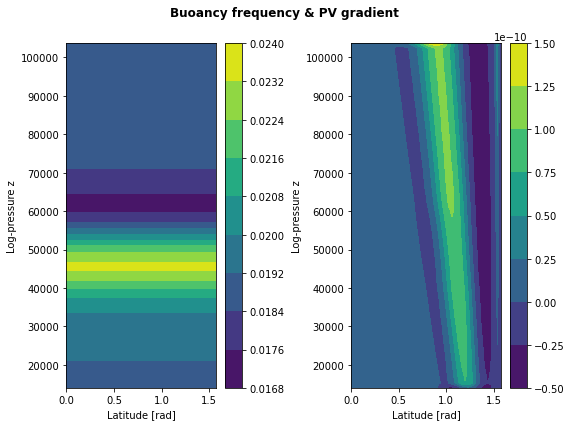

In [7]:
# plot buoancy frequency and pvgradient
fig, axes = plt.subplots(1,2,figsize=(8,6))

Cs = axes[0].contourf(grid.y,grid.z,np.sqrt(np.squeeze(N2)))
axes[0].set_ylabel('Log-pressure z')
axes[0].set_xlabel('Latitude [rad]')
plt.colorbar(Cs,ax=axes[0])

Cs = axes[1].contourf(grid.y,grid.z,np.squeeze(qy))
axes[1].set_ylabel('Log-pressure z')
axes[1].set_xlabel('Latitude [rad]')
plt.colorbar(Cs,ax=axes[1])

fig.suptitle('Buoancy frequency & PV gradient',weight='bold')
fig.tight_layout()

## Run Model

(71, 47)


Text(0.5, 1.0, 'Sponge_layer')

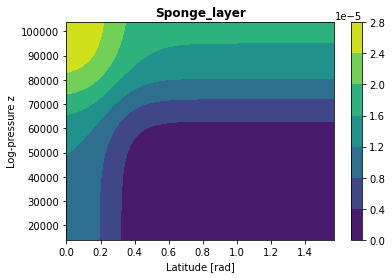

In [8]:
s=1
gammac = 0.05
freq = 0 # angular frequency in days**(-1)

matrix = Matrix(grid,s)

# Define sponge layer
damp = wave.damp(grid,basicstate['u'].values,s,gammac,freq)
rayd = wave.rayd(grid)
alpha = wave.alpha(grid)

print(rayd.shape)

ax = plt.axes()
C = ax.contourf(basicstate.lat,basicstate.lev,rayd)
ax.set_ylabel('Log-pressure z')
ax.set_xlabel('Latitude [rad]')
plt.colorbar(C)
ax.set_title('Sponge_layer',weight='bold')

In [9]:
# Run Model
f = matrix.forcing()
A = matrix.A(basicstate['qy'].values,
             basicstate['N2'].values,
             damp,
             rayd,
             alpha)

phi = matrix.solve(A,f)

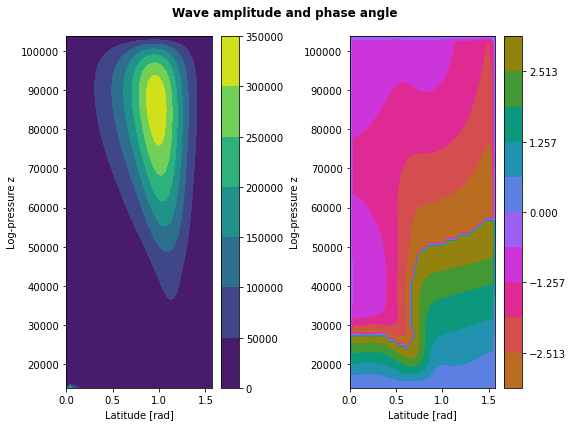

In [10]:
# Plot time-mean wave amplitude and phase
amplitude = wave.amplitude(grid,phi).mean(axis=0)
phase = wave.phase(grid,phi).mean(axis=0)

fig, axes = plt.subplots(1,2,figsize=(8,6))

# filled contours for amplitude
#levels = np.linspace(0,32000,11)
levels = None
C = axes[0].contourf(basicstate.lat,basicstate.lev,amplitude,levels=levels)
axes[0].set_ylabel('Log-pressure z')
axes[0].set_xlabel('Latitude [rad]')
plt.colorbar(C,ax=axes[0])

# filled contours for phase
levels = np.linspace(-np.pi,np.pi,11)
C = axes[1].contourf(basicstate.lat,basicstate.lev,phase,levels=levels,cmap=cm.phase)
axes[1].set_ylabel('Log-pressure z')
axes[1].set_xlabel('Latitude [rad]')
plt.colorbar(C,ax=axes[1])

fig.suptitle('Wave amplitude and phase angle',weight='bold')
fig.tight_layout()

/home/wolfgang/Arbeit/wavegeometry_model/src/anywave.py:227: RuntimeWarning: divide by zero encountered in true_divide
  result = - np.real((grid._fyy(phi)-grid.sn/grid.cs*grid._fy(phi))/phi)
/home/wolfgang/Arbeit/wavegeometry_model/src/anywave.py:227: RuntimeWarning: invalid value encountered in true_divide
  result = - np.real((grid._fyy(phi)-grid.sn/grid.cs*grid._fy(phi))/phi)
/tmp/ipykernel_5534/2387775429.py:2: RuntimeWarning: invalid value encountered in sqrt
  l = np.sqrt(wave.l2(grid,phi)).mean(axis=0)
/home/wolfgang/Arbeit/wavegeometry_model/src/anywave.py:238: RuntimeWarning: divide by zero encountered in true_divide
  result = - np.real(psizz/phi) * np.sqrt(grid.ez * N2)
/home/wolfgang/Arbeit/wavegeometry_model/src/anywave.py:238: RuntimeWarning: invalid value encountered in true_divide
  result = - np.real(psizz/phi) * np.sqrt(grid.ez * N2)
/tmp/ipykernel_5534/2387775429.py:3: RuntimeWarning: invalid value encountered in sqrt
  m = np.sqrt(wave.m2(grid,phi,basicstate['N2'].

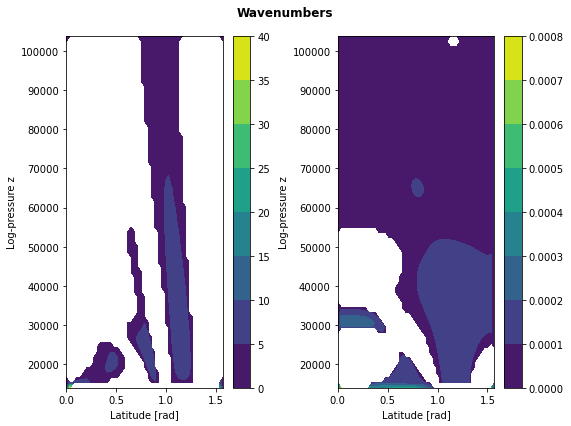

In [11]:
# Plot meridional and vertical wavenumber and refractive index
l = np.sqrt(wave.l2(grid,phi)).mean(axis=0)
m = np.sqrt(wave.m2(grid,phi,basicstate['N2'].values)).mean(axis=0)

fig, axes = plt.subplots(1,2,figsize=(8,6))

# filled contours for meridional wavenumber 
levels = None
C = axes[0].contourf(basicstate.lat,basicstate.lev,l,levels=levels)
axes[0].set_ylabel('Log-pressure z')
axes[0].set_xlabel('Latitude [rad]')
plt.colorbar(C,ax=axes[0])

# filled contours for vertical wavenumber
levels = None
C = axes[1].contourf(basicstate.lat,basicstate.lev,m,levels=levels)
axes[1].set_ylabel('Log-pressure z')
axes[1].set_xlabel('Latitude [rad]')
plt.colorbar(C,ax=axes[1])

fig.suptitle('Wavenumbers',weight='bold')
fig.tight_layout()

/tmp/ipykernel_5534/2565766429.py:1: RuntimeWarning: invalid value encountered in sqrt
  nref_alt = np.sqrt(wave.n2ref_alt(grid,basicstate['N2'].values,basicstate['qy'].values,
/tmp/ipykernel_5534/2565766429.py:4: RuntimeWarning: invalid value encountered in sqrt
  nref = np.sqrt(wave.n2ref(grid,phi,basicstate['N2'].values)).mean(axis=0)


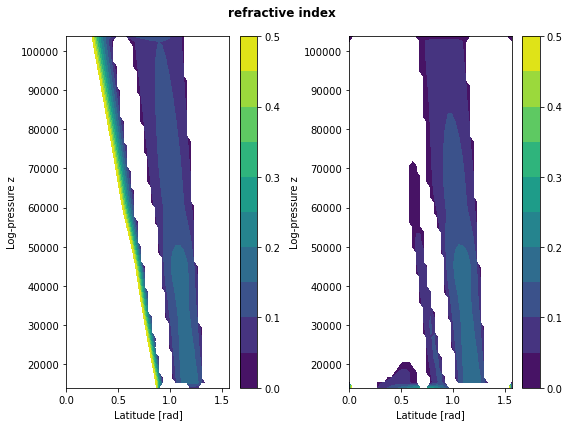

In [12]:
nref_alt = np.sqrt(wave.n2ref_alt(grid,basicstate['N2'].values,basicstate['qy'].values,
                                    basicstate['u'].values,s,freq)).mean(axis=0)

nref = np.sqrt(wave.n2ref(grid,phi,basicstate['N2'].values)).mean(axis=0)

fig, axes = plt.subplots(1,2,figsize=(8,6))

# filled contours for refractive index
levels = np.linspace(0,0.5,11)
C = axes[0].contourf(basicstate.lat,basicstate.lev,nref_alt,levels=levels)
axes[0].set_ylabel('Log-pressure z')
axes[0].set_xlabel('Latitude [rad]')
plt.colorbar(C,ax=axes[0])

levels = np.linspace(0,0.5,11)
C = axes[1].contourf(basicstate.lat,basicstate.lev,nref,levels=levels)
axes[1].set_ylabel('Log-pressure z')
axes[1].set_xlabel('Latitude [rad]')
plt.colorbar(C,ax=axes[1])

fig.suptitle('refractive index ',weight='bold')
fig.tight_layout()

# Conclusion

Apparently, the model numerics work ok. At least, the fine scale oscillations seen in wavenumbers and vorticity gradient computed from IFS model level output don't show up. Based on coarse contours in the above plots, it might be desireable to increase resolution and, potentially, implement higher order accurate finite differences. But overall, I'm confident that, currently, no major mistakes exist in the model code.

A downside of the model to be noted is that refractive indices computed either from wavenumber diagnostics or from basic state variables disaggree. Specifically, `nref_alt` gets very large in tropics & subtropics. That might be caused by QG limitations. `nref` computed from model variables doesn't show this because of the sponge. So far, I haven't spent much thought on the configuration of the sponge layer.
